# Combining Tianshou's PPO with our CorePolicy

This notebook is mostly meant as a test, and a showcase of how we can combine a CorePolicy with policies provided by Tianshou.

In [1]:
import tianshou as ts 
from tianshou.utils import TensorboardLogger

import torch
from torch.utils.tensorboard import SummaryWriter

import os
from datetime import datetime

from environments import Resetting
from networks import NetHackObsNet, GoalNetHackActor, GoalNetHackCritic
from policies import PPOBasedPolicy
from models import SelfModel, EnvModel
from intrinsic import ICM
from core import GoalCollector, GoalVectorReplayBuffer, GoalOnpolicyTrainer
from utils import EpochStatsPlotter

from nle.env.tasks import NetHackGold

## Setup

In [2]:
env = Resetting(NetHackGold())
device = torch.device("cpu")

In [3]:
num_train_envs = 5
num_test_envs = 5

train_envs = ts.env.DummyVectorEnv([lambda: env for _ in range(num_train_envs)])
test_envs = ts.env.DummyVectorEnv([lambda: env for _ in range(num_test_envs)])

In [4]:
obs_net = NetHackObsNet(env.observation_space, device=device)

actor_net = GoalNetHackActor(obs_net, env.action_space, device=device)
critic_net = GoalNetHackCritic(obs_net, device=device)

In [5]:
train_buf = GoalVectorReplayBuffer(100, num_train_envs)
test_buf = GoalVectorReplayBuffer(1, num_train_envs)

env_model = EnvModel() # this does nothing, for the moment
self_model = SelfModel(obs_net, env.action_space, train_buf, ICM, her_horizon=3, device=device)

In [6]:
# using a single optimizer for actor and critic simplifies the training loop and is more computationally efficient
# BUT gradient updates in one network will influence the gradient updates in the other, and this might create unexpected problems...
combined_params = set(list(actor_net.parameters()) + list(critic_net.parameters()))
optimizer = torch.optim.Adam(combined_params, lr=3e-4)

## Custom PPO-based policy

In [7]:
policy = PPOBasedPolicy(
    self_model=self_model,
    env_model=env_model,
    act_net=actor_net, 
    critic_net=critic_net, 
    optim=optimizer,
    action_space=env.action_space,
    observation_space=env.observation_space,
    device=device
)

In [8]:
train_collector = GoalCollector(policy, train_envs, train_buf)
test_collector = GoalCollector(policy, test_envs, test_buf)

In [9]:
num_epochs = 5
num_steps_per_epoch = 100

step_per_collect = 10
episode_per_test = 5
batch_size = 10

timestamp = datetime.now().strftime("%d%m%Y-%H%M%S")
log_path = os.path.join("../logs", "ppo_based", timestamp)
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [10]:
trainer = GoalOnpolicyTrainer(
    policy=policy, 
    train_collector=train_collector, 
    test_collector=test_collector,
    repeat_per_collect=1,
    max_epoch=num_epochs,
    step_per_epoch=num_steps_per_epoch,
    step_per_collect=step_per_collect,
    episode_per_test=episode_per_test,
    batch_size=batch_size,
    logger=logger,
    device=device
)

In [11]:
epoch_stats = []
for epoch_stat in trainer:
    epoch_stats.append(epoch_stat)

Epoch #1: 101it [00:02, 37.81it/s, env_step=100, gradient_step=0, int_rew=37.5754, len=0, n/ep=0, n/st=10, rew=-0.0070]                         


Epoch #1: test_reward: -12.182226 ± 11.792511, best_reward: -0.005186 ± 0.076696 in #0


Epoch #2: 101it [00:02, 41.59it/s, env_step=200, gradient_step=0, int_rew=6477.5430, len=0, n/ep=0, n/st=10, rew=-0.0030]                         


Epoch #2: test_reward: -2.142005 ± 1.863636, best_reward: -0.005186 ± 0.076696 in #0


Epoch #3: 101it [00:02, 41.41it/s, env_step=300, gradient_step=0, int_rew=235229.2812, len=0, n/ep=0, n/st=10, rew=-0.0030]                         


Epoch #3: test_reward: -2.766010 ± 2.226287, best_reward: -0.005186 ± 0.076696 in #0


Epoch #4: 101it [00:02, 41.37it/s, env_step=400, gradient_step=0, int_rew=1806095.7500, len=0, n/ep=0, n/st=10, rew=-0.0030]                         


Epoch #4: test_reward: -3.146014 ± 2.307750, best_reward: -0.005186 ± 0.076696 in #0


Epoch #5: 101it [00:02, 41.09it/s, env_step=500, gradient_step=0, int_rew=9476178.0000, len=0, n/ep=0, n/st=10, rew=-0.0030]                         


Epoch #5: test_reward: -2.636011 ± 2.410685, best_reward: -0.005186 ± 0.076696 in #0


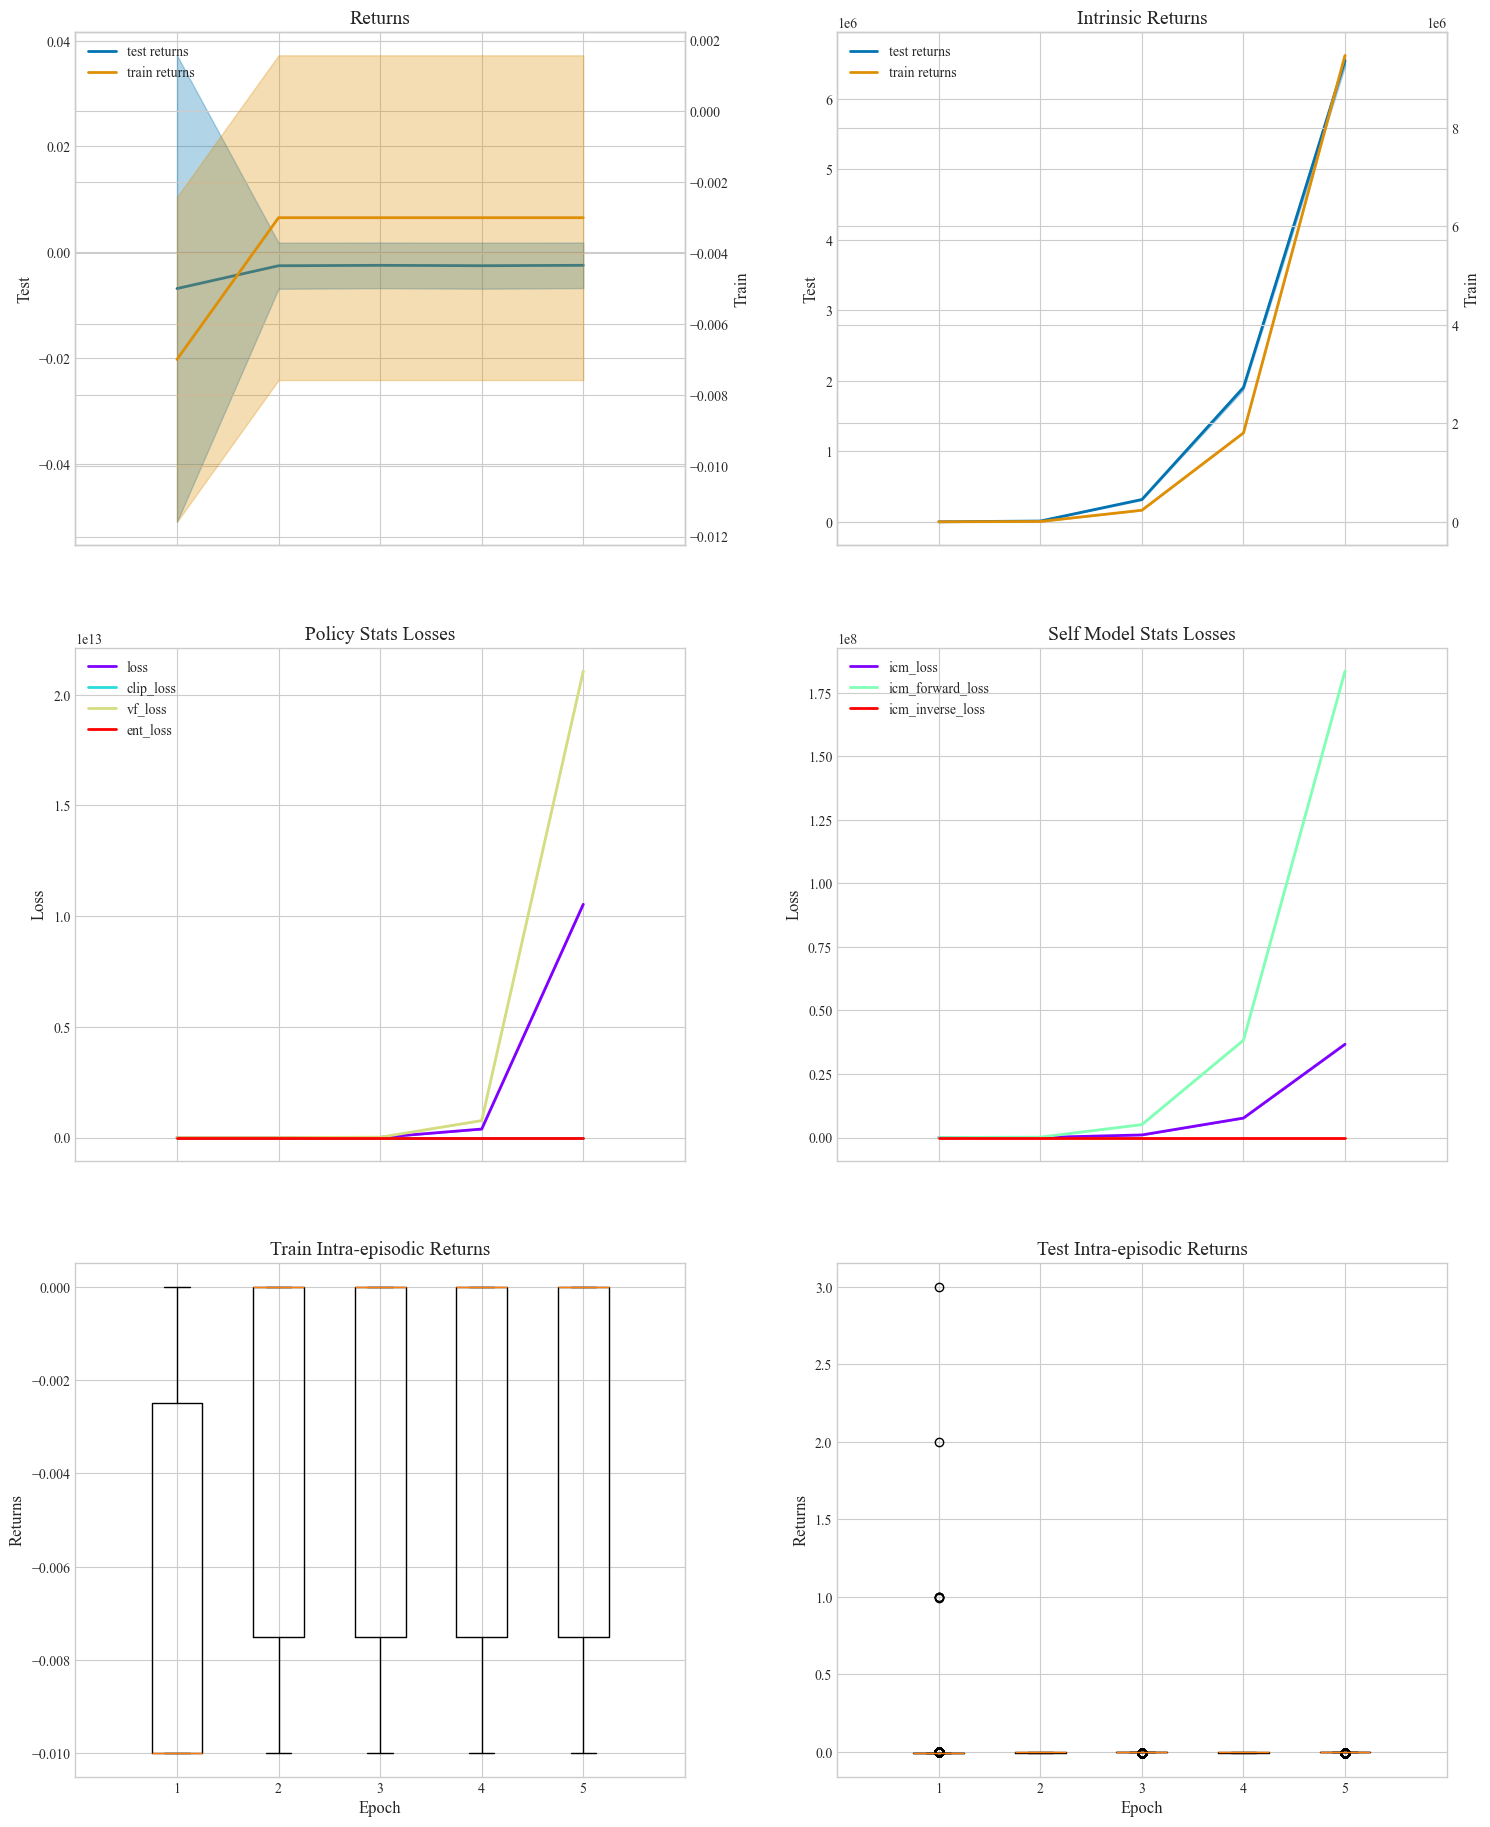

In [12]:
plotter = EpochStatsPlotter(epoch_stats)

# TODO the values of the losses and the intrinsic returns seem way too high, are they correct?
plotter.plot()